<a href="https://colab.research.google.com/github/ods199812-afk/Bayesian-/blob/main/Bayesian_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Packages

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.qmc import Sobol

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from scipy.stats import norm
from scipy.stats import ttest_rel

# Branin


## Branin & Pre-Exploration

-3.141592653589793 12.275 0.39788735772973816
3.141592653589793 2.275 0.39788735772973816
9.42477796076938 2.475 0.39788735772973816


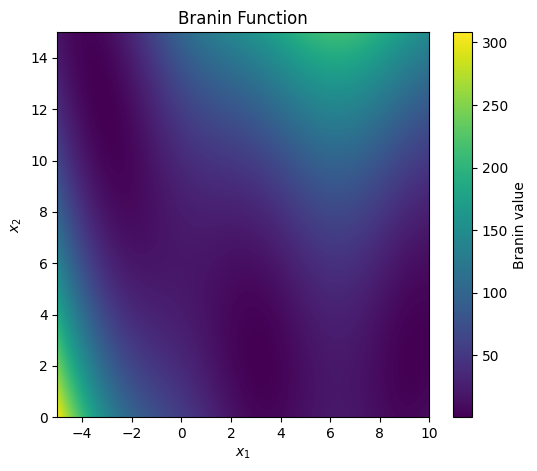

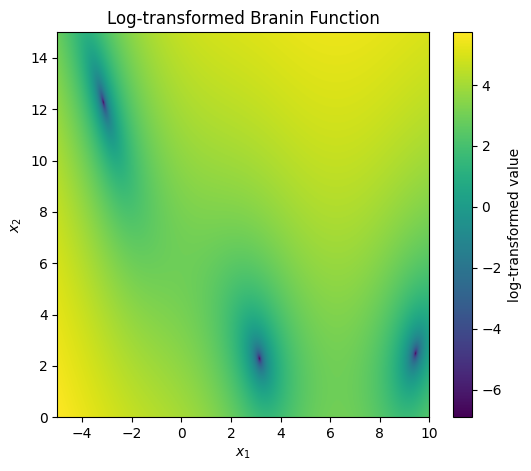

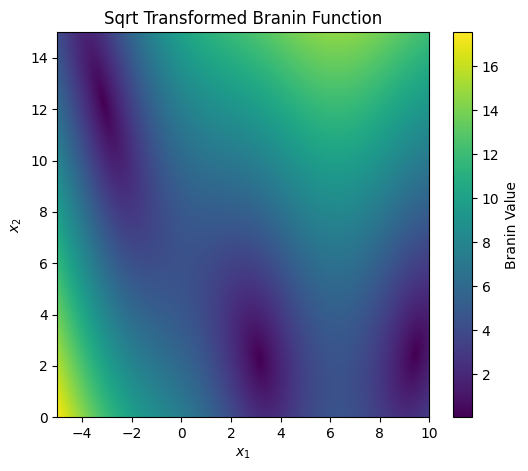

In [ ]:
def Branin(x1, x2):
    a = 1.0
    b = 5.1 / (4 * np.pi**2)
    c = 5.0 / np.pi
    r = 6.0
    s = 10.0
    t = 1.0 / (8 * np.pi)

    return a * (x2 - b * x1**2 + c * x1 - r)**2 + s * (1 - t) * np.cos(x1) + s

test_points = [
    (-np.pi, 12.275),
    ( np.pi,  2.275),
    ( 3*np.pi, 2.475)
]
for x1_val, x2_val in test_points:
    print(x1_val, x2_val, Branin(x1_val, x2_val))

N = 1000
x1_min, x1_max = -5, 10
x2_min, x2_max = 0, 15
x1 = np.linspace(x1_min, x1_max, N)
x2 = np.linspace(x2_min, x2_max, N)

X1, X2 = np.meshgrid(x1, x2)
Y = Branin(X1, X2)

# Y
Y_shift = Y - Y.min() + 1e-3
Y_log = np.log(Y_shift)
Y_sqrt = np.sqrt(Y_shift)

# 1. Branin
plt.figure(figsize=(6, 5))
plt.imshow(
    Y,
    extent=[x1_min, x1_max, x2_min, x2_max],
    origin="lower",
    aspect="auto"
)
plt.colorbar(label="Branin value")
plt.title("Branin Function")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.show()

# 2. log transform
plt.figure(figsize=(6, 5))
plt.imshow(
    Y_log,
    extent=[x1_min, x1_max, x2_min, x2_max],
    origin="lower",
    aspect="auto"
)
plt.colorbar(label="log-transformed value")
plt.title("Log-transformed Branin Function")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.show()

# 3. sqrt transform
plt.figure(figsize =(6,5))
plt.imshow(
    Y_sqrt,
    extent = [x1_min, x1_max, x2_min, x2_max],
    origin = "lower",
    aspect = "auto"
)
plt.colorbar(label = "Branin Value")
plt.title("Sqrt Transformed Branin Function")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.show()

## Functions
**GP fitting :**

with random numbers from 32 points = x_train within the range [x1_min, x1_max]
and [x2_min, x2_max], outputs Branin Value as f(x1, x2) = y_"model". Given
y_"model", trains GP with constant * RBF kernel. finall have x_train/y_train  and corresponding GP with learned parameters.



---



**Population plotting:**

Plot "model" with "model", Observe how f(x) is distributed.




---



**gp_mean_std:**

Given GP from GP_fitting, calculate GP posterior mean & std.




---

**gp_diagnostics:**

Given Y_train, calculate mu & std ( same as gp_mean_std ), compute z_score ( z_mean & z_std)  , BIC and log_marginal_Likelihood


In [ ]:
def population_plotting(N, x1_min, x1_max, x2_min, x2_max, model):

  x1 = np.linspace(x1_min, x1_max, N)
  x2 = np.linspace(x2_min, x2_max, N)

  X1, X2 = np.meshgrid(x1, x2)
  Y = Branin(X1, X2)

  if model == "shift":
    Y_shift = Y - Y.min() + 1e-3
  elif model == "log":
    Y_shift = np.log(Y)
  elif model == "sqrt":
    Y_shift = np.sqrt(Y)

  plt.figure(figsize = (10, 6))
  plt.imshow(
      Y_shift,
      extent = [x1_min, x1_max, x2_min, x2_max],
      origin = "lower",
      aspect = "auto"
  )
  plt.colorbar(label = model + "value")
  plt.title(model + "Transformed Branin Function")
  plt.show()

### ------------------------------------------------------------------------------------------------------------------------------------------------------------------------- ###

def GP_fitting(model, x1_min, x1_max, x2_min, x2_max):
  sampler = Sobol(d=2, scramble=True, seed = 0)
  u = sampler.random_base2(m=5)
  X_train = np.empty_like(u)
  X_train[:,0] = x1_min + (x1_max - x1_min) * u[:,0]
  X_train[:,1] = x2_min + (x2_max - x2_min) * u[:,1]

  if model == "shift":
    Y_train = Branin(X_train[:,0], X_train[:,1])
  elif model == "log":
    Y_train = np.log(Branin(X_train[:,0], X_train[:,1]))
  elif model == "sqrt":
    Y_train = np.sqrt(Branin(X_train[:,0], X_train[:,1]))


  kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=[1.0, 1.0], length_scale_bounds=(1e-2, 1e2))

  gp = GaussianProcessRegressor(
      kernel=kernel,
      alpha = 1e-6,
      normalize_y = True,
      n_restarts_optimizer = 5,
      random_state = 0

  )

  gp.fit(X_train, Y_train)

  print("Learned kernel:", gp.kernel_)
  return gp, X_train, Y_train

### ------------------------------------------------------------------------------------------------------------------------------------------------------------------------- ###

def gp_mean_std(N, x1_min, x1_max, x2_min, x2_max, gp, title_suffix=""):
    """
    在 Branin 的定义域上，用给定的 gp 模型画 posterior mean 的 heatmap
    """
    # 和 population_plotting 一样的网格
    x1 = np.linspace(x1_min, x1_max, N)
    x2 = np.linspace(x2_min, x2_max, N)
    X1, X2 = np.meshgrid(x1, x2)

    # 拼成 (N*N, 2) 的点，喂给 gp.predict
    X_grid = np.column_stack([X1.ravel(), X2.ravel()])
    mu, std = gp.predict(X_grid, return_std=True)
    Mu = mu.reshape(N, N)

    plt.figure(figsize=(10, 6))
    plt.imshow(
        Mu,
        extent=[x1_min, x1_max, x2_min, x2_max],
        origin='lower',
        aspect='auto'
    )
    plt.colorbar(label="GP posterior mean")
    plt.title("GP mean " + title_suffix)
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    plt.show()

    return mu, std

def gp_diagnostics(gp,              # 拟合好的 GP 模型
                   X_train, Y_train,
                   x1_min, x1_max, x2_min, x2_max,
                   N=200,
                   model_name="shift"):
    """
    对给定的 GP 模型做诊断：
      1. 画 posterior std 的 heatmap（网格上的）
      2. 在训练点上算 z-scores 并画直方图
      3. 计算 log marginal likelihood 和 BIC
    返回一个 dict 存结果，方便后面对比
    """

    # ---------- 1. 在网格上画 posterior std heatmap ----------
    x1 = np.linspace(x1_min, x1_max, N)
    x2 = np.linspace(x2_min, x2_max, N)
    X1, X2 = np.meshgrid(x1, x2)

    X_grid = np.column_stack([X1.ravel(), X2.ravel()])
    mu_grid, std_grid = gp.predict(X_grid, return_std=True)
    Std = std_grid.reshape(N, N)

    plt.figure(figsize=(6, 5))
    plt.imshow(
        Std,
        extent=[x1_min, x1_max, x2_min, x2_max],
        origin="lower",
        aspect="auto"
    )
    plt.colorbar(label="posterior std")
    plt.scatter(X_train[:, 0], X_train[:, 1],
                c="white", s=20, edgecolors="k", label="Sobol samples")
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    plt.title(f"GP posterior standard deviation ({model_name} model)")
    plt.legend(loc="upper right")
    plt.show()

    # ---------- 2. 在训练点上算 z-scores ----------
    mu_train, std_train = gp.predict(X_train, return_std=True)
    residuals = Y_train - mu_train
    z = residuals / std_train

    z_mean = np.mean(z)
    z_std = np.std(z)
    print(f"{model_name} model: z mean =", z_mean)
    print(f"{model_name} model: z std  =", z_std)

    plt.figure(figsize=(5, 4))
    plt.hist(z, bins=10, density=True, alpha=0.7)
    plt.xlabel("z-score")
    plt.ylabel("density")
    plt.title(f"Standardized residuals on training points ({model_name})")
    plt.show()

    # ---------- 3. log marginal likelihood & BIC ----------
    log_ml = gp.log_marginal_likelihood_value_
    n = len(Y_train)
    k = gp.kernel_.theta.size + 1   # kernel 参数 + 噪声

    bic = k * np.log(n) - 2 * log_ml
    print(f"{model_name} model: log marginal likelihood:", log_ml)
    print(f"{model_name} model: BIC:", bic)

    # 把关键结果 return 出去，后面可以存起来做对比表格
    return {
        "z_mean": z_mean,
        "z_std": z_std,
        "log_ml": log_ml,
        "bic": bic
    }


## Raw Branin vs. GP_RBF

**Raw Y vs Y_train:**



1.   GP_train, X_train (32 points), y_train { f(x1,x2) }
2.   plot raw data
3.   compute mu_Y_train, std_Y_train, BIC, Log_ML



Learned kernel: 18.5**2 * RBF(length_scale=[4.78, 42])


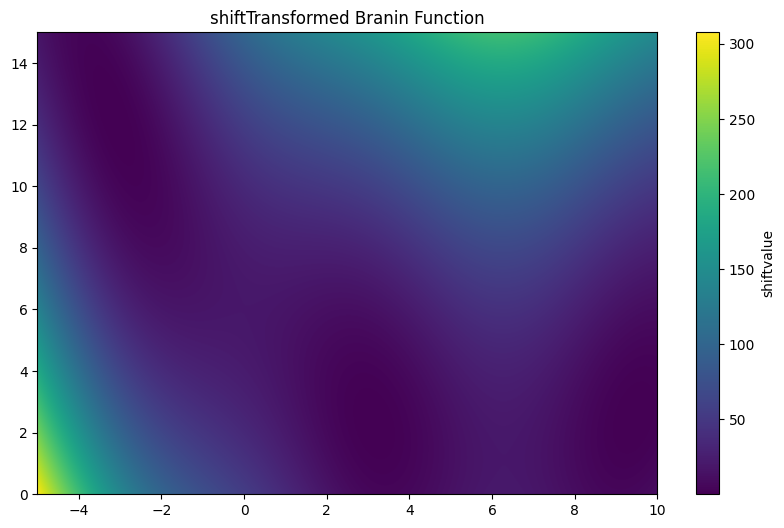

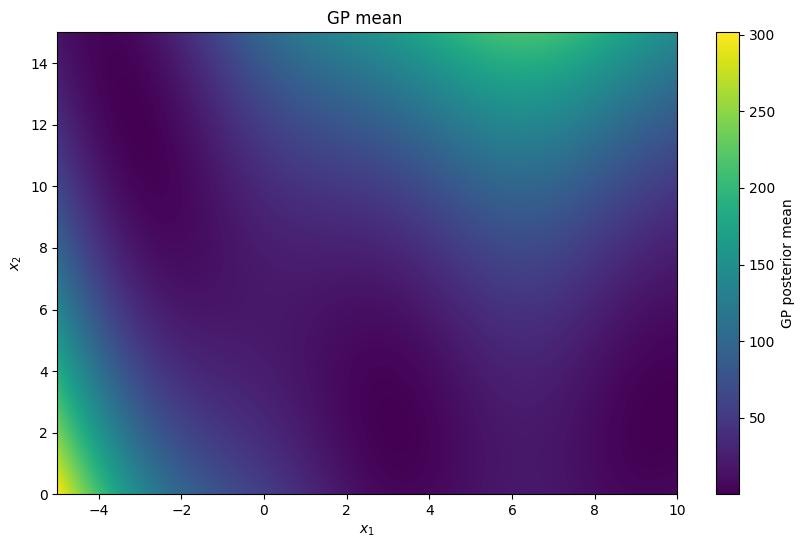

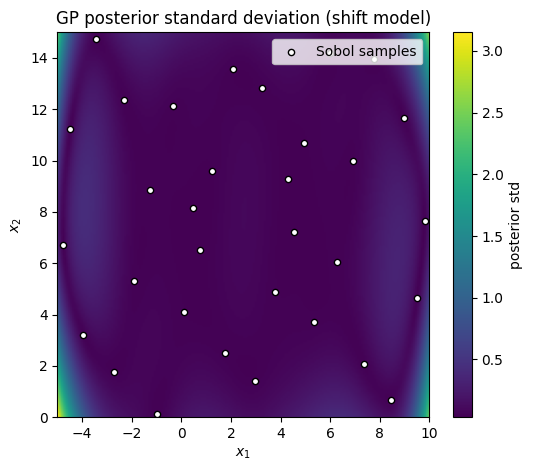

shift model: z mean = 0.019326665935290213
shift model: z std  = 0.35995588330356193


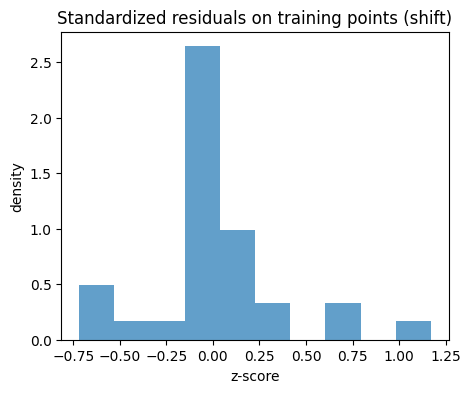

shift model: log marginal likelihood: 18.911008645232975
shift model: BIC: -23.959073679267043


In [ ]:
gp_shift, X_shift, Y_shift = GP_fitting("shift", x1_min, x1_max, x2_min, x2_max)
population_plotting(1000, x1_min, x1_max, x2_min, x2_max, "shift")

mu_shift, std_shift = gp_mean_std(1000, x1_min, x1_max, x2_min, x2_max, gp_shift)

diag_shift = gp_diagnostics(
    gp_shift, X_shift, Y_shift,
    x1_min, x1_max, x2_min, x2_max,
    N=200,
    model_name="shift"
)


## Log Branin vs. Log GP

**Log Y vs. Log y_trian:**

1.   GP_train, X_train (32 points), y_train { f(x1,x2) }
2.   plot log form data
3.   compute mu_Y_train, std_Y_train, BIC, Log_ML



Learned kernel: 1.21**2 * RBF(length_scale=[1.91, 5.47])


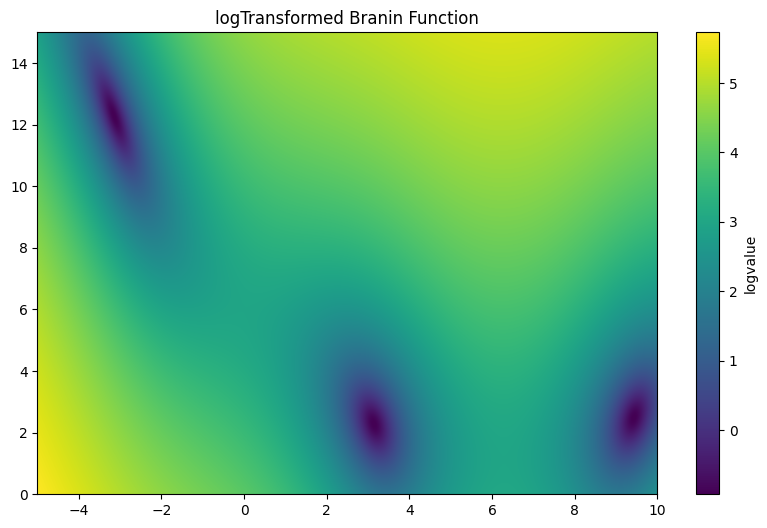

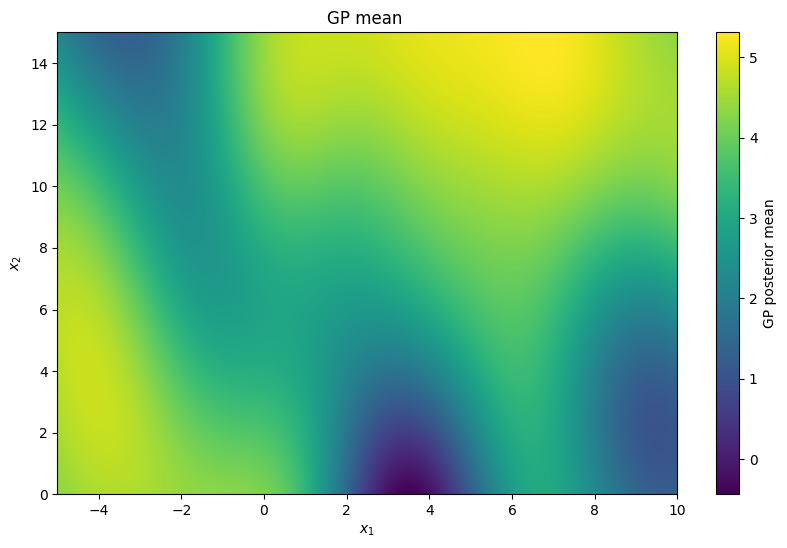

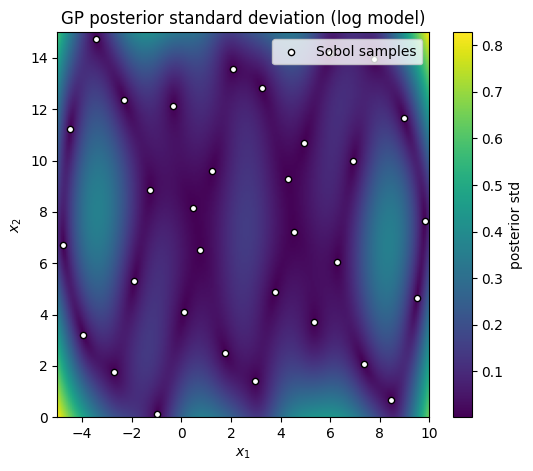

log model: z mean = -2.2285103351478127e-05
log model: z std  = 0.009058104067414828


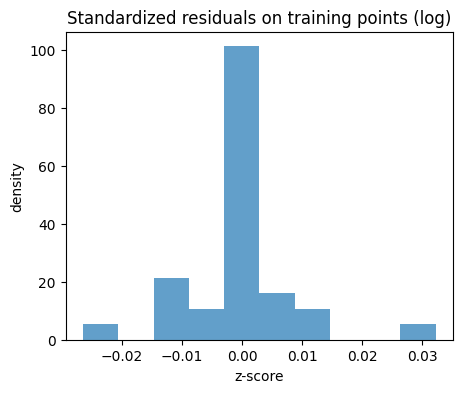

log model: log marginal likelihood: -24.377558800410917
log model: BIC: 62.61806121202074


In [ ]:
gp_log, X_log, Y_log = GP_fitting("log", x1_min, x1_max, x2_min, x2_max)

population_plotting(1000, x1_min, x1_max, x2_min, x2_max, "log")

mu_log, std_log = gp_mean_std(1000, x1_min, x1_max, x2_min, x2_max, gp_log)

diag_log = gp_diagnostics(
    gp_log, X_log, Y_log,
    x1_min, x1_max, x2_min, x2_max,
    N=200,
    model_name="log"
)


## Sqrt Branin vs. Sqrt GP

Learned kernel: 1.29**2 * RBF(length_scale=[2.48, 8.1])


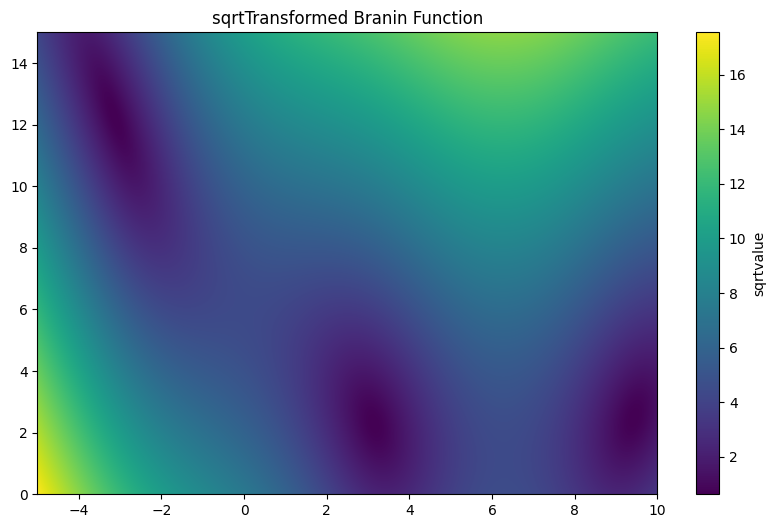

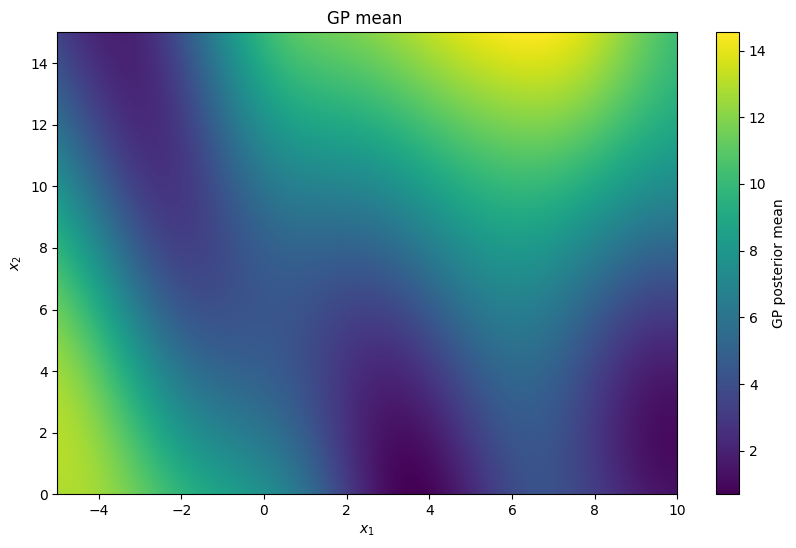

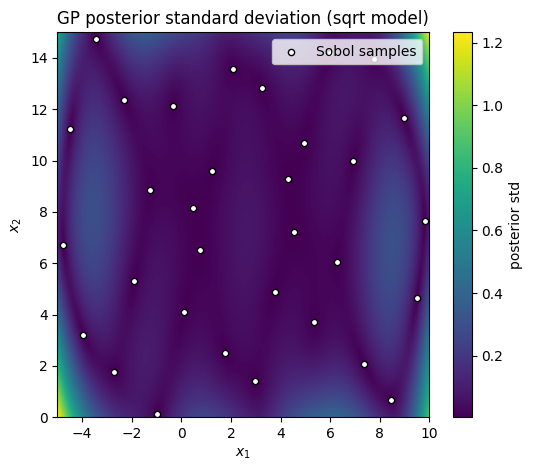

sqrt model: z mean = 6.272048693267739e-05
sqrt model: z std  = 0.030345315186382622


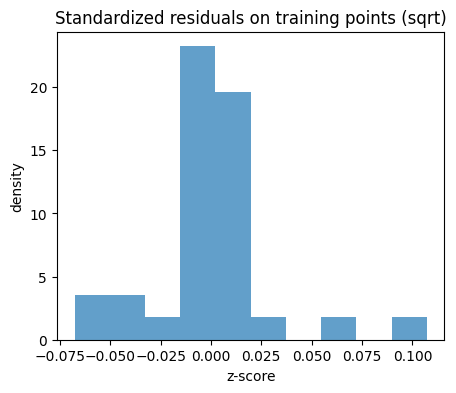

sqrt model: log marginal likelihood: -3.3484796402395034
sqrt model: BIC: 20.559902891677915


In [ ]:
gp_sqrt, X_sqrt, Y_sqrt = GP_fitting("sqrt", x1_min, x1_max, x2_min, x2_max)

population_plotting(1000, x1_min, x1_max, x2_min, x2_max, "sqrt")

mu_sqrt, std_sqrt = gp_mean_std(1000, x1_min, x1_max, x2_min, x2_max, gp_sqrt)

diag_sqrt = gp_diagnostics(
    gp_sqrt, X_sqrt, Y_sqrt,
    x1_min, x1_max, x2_min, x2_max,
    N=200,
    model_name="sqrt"
)


In [ ]:
print("diag_sqrt of Y is:", "mean:",f"{diag_sqrt['z_mean']:.3f}", "std:", f"{diag_sqrt['z_std']:.3f}", "log_ml:", f"{diag_sqrt['log_ml']:.3f}", "bic:", f"{diag_sqrt['bic']:.3f}")
print("diag_shift of Y is:", "mean:",f"{diag_shift['z_mean']:.3f}", "std:", f"{diag_shift['z_std']:.3f}", "log_ml:", f"{diag_shift['log_ml']:.3f}", "bic:", f"{diag_shift['bic']:.3f}")
print("diag_log of Y is:", "mean:", f"{diag_log['z_mean']:.3f}", "std:", f"{diag_log['z_std']:.3f}", "log_ml:", f"{diag_log['log_ml']:.3f}", "bic:", f"{diag_log['bic']:.3f}")

diag_sqrt of Y is: mean: 0.000 std: 0.030 log_ml: -3.348 bic: 20.560
diag_shift of Y is: mean: 0.019 std: 0.360 log_ml: 18.911 bic: -23.959
diag_log of Y is: mean: -0.000 std: 0.009 log_ml: -24.378 bic: 62.618


# SVM & LDA

## Function



---



1.   KDE plot


  First step: Plot Kernel Density Estimate, see distribution of raw data


---



2.   fit_ gp

  Second step: same as GP fitting for Branin, outputs Y_train and trained GP.


---
3.   Diagostices_gp

  Third step: outputs BIC/ mu / std / Log ML for Y_train







In [ ]:
def kde_plot(y, title, ax):

  sns.kdeplot(y, fill = True, ax = ax)
  ax.set_title(title + " " + "kde")
  ax.set_xlabel(title)
  ax.set_ylabel("density")

### ---------------------------------------------------------------------------------------------------------------- ###

def fit_gp(model, x, y, random_state = 0):

  if model == "raw":
    y_train = y.copy()
  elif model == "log":
    y_train = np.log(y)
  elif model == "sqrt":
    y_train = np.sqrt(y)
  else:
    raise ValueError("Invalid model name")

  kernel = C(1.0, (1e-3, 1e3)) * RBF(
      length_scale = np.ones(3),
      length_scale_bounds = (1e-2, 1e2)
  )

  gp = GaussianProcessRegressor(
      kernel = kernel,
      alpha = 1e-6,
      normalize_y = True,
      n_restarts_optimizer = 5
  )

  gp = gp.fit(x, y_train)
  print("Learned kernel:", gp.kernel_)
  return gp, y_train

### ---------------------------------------------------------------------------------------------------------------- ###

def diagnostics_gp(x, y, gp):

  mu, std = gp.predict(x, return_std = 1)

  residuals = y - mu
  z = residuals / std

  print("z mean:", np.mean(z))
  print("z std:", np.std(z))

  plt.figure(figsize = (5,4))
  sns.histplot(z, bins = 20, kde = True, stat = "density")
  plt.xlabel("z-score")
  plt.ylabel("density")
  plt.title("Standardized residuals on training points")
  plt.show()

  n = len(y)
  log_ml = gp.log_marginal_likelihood_value_
  bic = gp.kernel_.theta.size * np.log(n) - 2 * log_ml

  print("log marginal likelihood:", log_ml)
  print("BIC:", bic)

  return mu, std


## Data

In [ ]:
url_svm = "https://raw.githubusercontent.com/mwhoffman/benchfunk/refs/heads/master/benchfunk/functions/data/svm.csv"
df_svm = pd.read_csv(url_svm, header = None)
df_svm.head()
url_lda = "https://raw.githubusercontent.com/mwhoffman/benchfunk/refs/heads/master/benchfunk/functions/data/lda.csv"
df_lda = pd.read_csv(url_lda, header = None)
df_lda.head()

,0,1,2,3,4
0,1.0,4.0,16.0,2014.255351,36393.19
1,0.9,1024.0,4096.0,1680.540179,36419.51
2,0.6,1024.0,4096.0,1328.191297,24219.85
3,0.6,16.0,4.0,2859.440420,18862.01
4,0.7,1.0,4096.0,1313.263743,11218.42


## Kernel Density Estimate

**Raw:**

raw data of SVM and LDA are both left tailed

**Log:**

log-transformed Data of SVM and LDA are also left tailed

**Sqrt:**

Sqrt-transformed Data of SVM and LDA are also left tailed

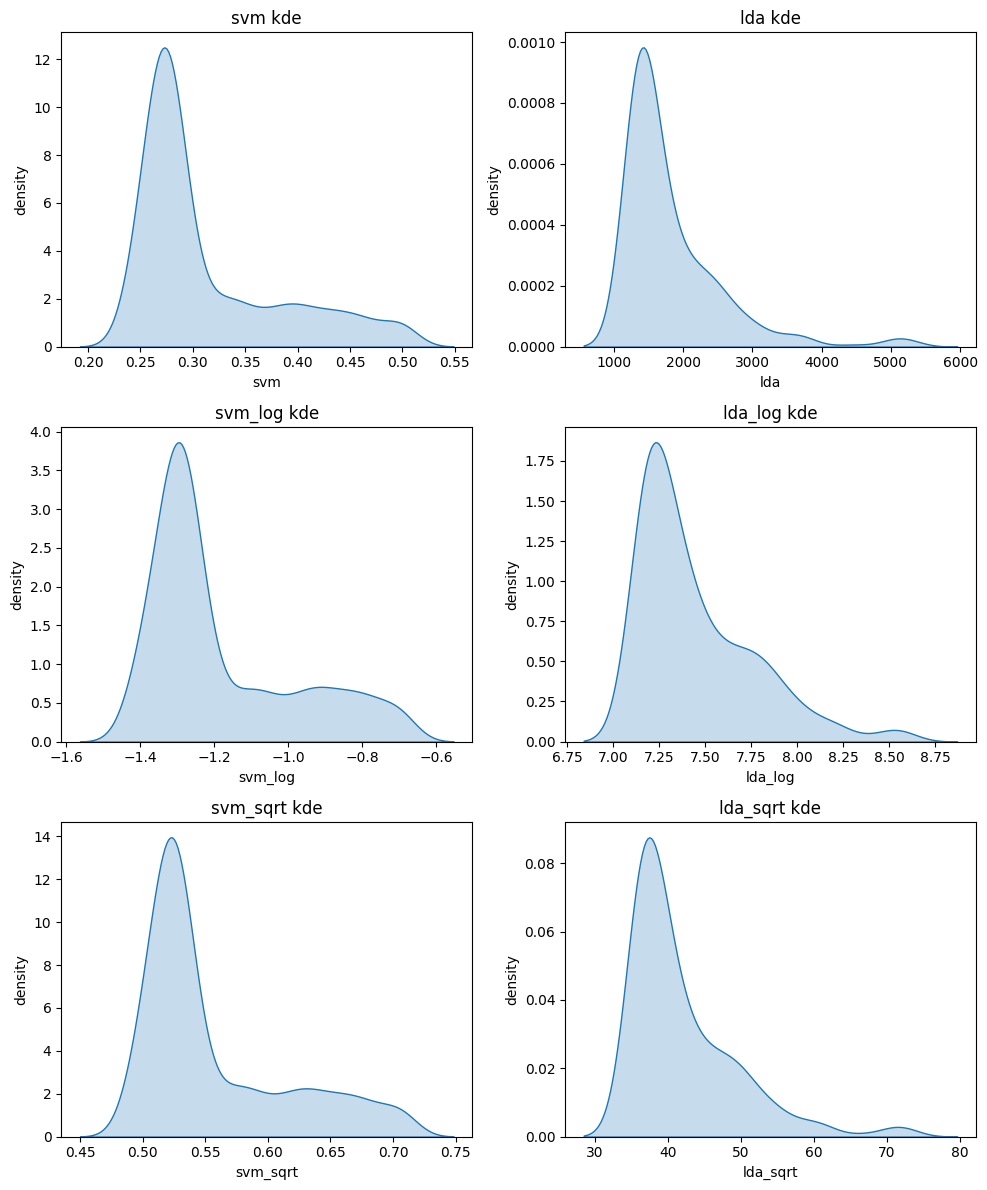

In [ ]:
svm_x = df_svm.iloc[:,:3].values
svm_y = df_svm.iloc[:,3].values

lda_x = df_lda.iloc[:,:3].values
lda_y = df_lda.iloc[:,3].values


fig, axs = plt.subplots(3, 2, figsize=(10, 12))

kde_plot(svm_y,          "svm",      axs[0, 0])
kde_plot(lda_y,          "lda",      axs[0, 1])
kde_plot(np.log(svm_y),  "svm_log",  axs[1, 0])
kde_plot(np.log(lda_y),  "lda_log",  axs[1, 1])
kde_plot(np.sqrt(svm_y), "svm_sqrt", axs[2, 0])
kde_plot(np.sqrt(lda_y), "lda_sqrt", axs[2, 1])

plt.tight_layout()
plt.show()


## BIC, Marginal Likelihood, Mean, Std, Z_score

**Learned Parameters:**

 fit_gp returns learned parameters for SVM and LDA with kernel (constant * RBF) \


---


 **SVM**

 Parameters : [0.149 , 0.118, 0.01] \
 Z_mean : -3,7 \
 Z_std : 0.05  
 Log ML: -1143  
 BIC : 2513



---
**LDA**

 Parameters : [0.175 , 12.8, 1.89] \
 Z_mean : 3.58 \
 Z_std : 0.06
 Log ML: -62  
 BIC : 148  




/usr/local/lib/python3.12/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 2 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Learned kernel: 1.72**2 * RBF(length_scale=[2.55, 0.118, 0.01])
Learned kernel: 1.12**2 * RBF(length_scale=[0.175, 12.8, 1.89])
z mean: -4.219441711926405e-05
z std: 0.06388472979466492


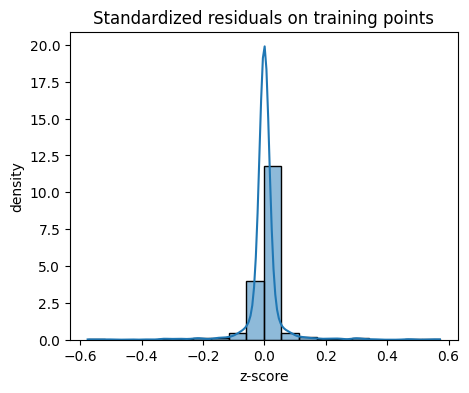

log marginal likelihood: -1090.4087671613681
BIC: 2209.7944443851497
z mean: 3.578130910147259e-05
z std: 0.061444075055310424


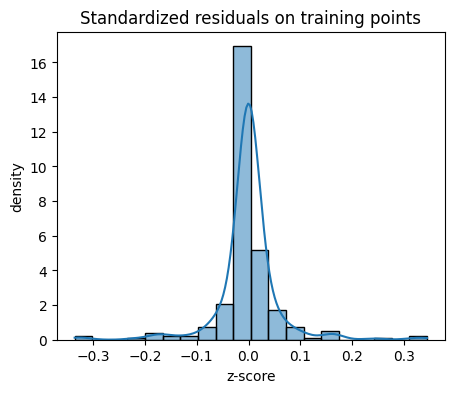

log marginal likelihood: -62.99802643644813
BIC: 148.64789479344003


(array([2014.23858224, 1680.5448758 , 1328.18662686, 2859.42029761,
        1313.24588282, 1271.87018275, 2630.4303948 , 2547.76010884,
        1558.07276853, 1278.12381955, 1361.31677298, 1800.43147077,
        2084.89118754, 1349.81235281, 2079.80132243, 3624.20449345,
        1749.48473491, 1310.07951765, 1343.80254218, 1983.65336881,
        2804.76833197, 1427.85324335, 1317.26914689, 5000.31051453,
        1637.66078649, 1537.86665733, 2040.5361571 , 5022.49874544,
        1472.70266488, 1572.9441876 , 1528.55123546, 1631.07182561,
        1541.96953117, 1468.34321287, 2968.61166192, 1886.93621496,
        2101.85784563, 2601.4064432 , 1506.41599648, 1271.58381932,
        2524.23704304, 2250.71005633, 2566.29879154, 1630.24867072,
        1836.76697001, 1266.17007809, 1364.83680049, 1435.194018  ,
        3053.62130045, 1268.0701813 , 1293.20468391, 1718.84242556,
        2045.70245914, 1730.22640789, 1369.04096036, 1454.54384364,
        1353.92835601, 2240.04651973, 1521.80606

In [ ]:
gp_svm, y_train_svm = fit_gp("raw", svm_x, svm_y)
gp_lda, y_train_lda = fit_gp("raw", lda_x, lda_y)
# mean_std_gp(x, y, gp)

diagnostics_gp(svm_x, y_train_svm, gp_svm)
diagnostics_gp(lda_x, y_train_lda, gp_lda)

# Bayesian Optimization

## Function




---



1.   fit_gp_subset
2.   expected_improvement
3.   bo_run_once_with_init
4.   random_search_once_with_init
5.   multi_runs
6.   compute_gap
7.   plot_gap_curves
8.   run_bo_vs_random_experiment







In [ ]:
def fit_gp_subset(X_sub, y_sub, fixed_kernel, random_state=0):
    """
    在当前子集 (X_sub, y_sub) 上拟合 GP，
    kernel 参数固定为 fixed_kernel，不再重新优化。
    """
    gp = GaussianProcessRegressor(
        kernel=fixed_kernel,
        alpha=1e-6,
        normalize_y=True,
        optimizer=None,          # 很关键：不再调 kernel 了
        random_state=random_state,
    )
    gp.fit(X_sub, y_sub)
    return gp

## —————————————————————————————————————————————————————————————— ##

def expected_improvement(mu, std, y_best, minimize = True):
    """
    mu, sigma: GP 在候选点上的预测均值和标准差（numpy 数组）
    f_best:    当前已经观测到的最小目标值（在同一个变换空间里）
    xi:        小的 positive 数，可以增加 exploration，先用 0 就行
    """
    if minimize:
      z = (y_best - mu) / std
      ei = (y_best - mu) * norm.cdf(z) + std * norm.pdf(z)

    ei[ei < 1e-9] = 0

    return ei


## —————————————————————————————————————————————————————————————— ##

def bo_run_once_with_init(
    X_all, y_all,
    fixed_kernel,
    init_idx,
    n_iter=30,
    random_state=0,
    model = "shift"
):
    chosen_idx = list(init_idx)
    best_y_history = []

    if model == "shift":
      y_all_transform = y_all.copy()
    elif model == "log":
      y_all_transform = np.log(y_all.copy())
    elif model == "sqrt":
      y_all_transform = np.sqrt(y_all.copy())

    for t in range(n_iter):
        x_train = X_all[chosen_idx]
        y_train = y_all_transform[chosen_idx]

        gp = fit_gp_subset(x_train, y_train, fixed_kernel, random_state=random_state)

        mu_all, std_all = gp.predict(X_all, return_std=True)
        y_best = y_train.min()
        ei_all = expected_improvement(mu_all, std_all, y_best)

        ei_all[chosen_idx] = -np.inf

        next_idx = int(np.argmax(ei_all))
        chosen_idx.append(next_idx)

        best_y_so_far = y_all[chosen_idx].min()
        best_y_history.append(best_y_so_far)

    return chosen_idx, np.array(best_y_history)



## —————————————————————————————————————————————————————————————— ##


def random_search_once_with_init(
    X_all, y_all,
    init_idx,
    n_iter=30,
    random_state=0
):
    rng = np.random.default_rng(random_state)
    n_total = X_all.shape[0]

    chosen_idx = list(init_idx)
    best_y_so_far = y_all[chosen_idx].min()
    best_y_history = []
    best_y_history.append(best_y_so_far)

    for t in range(1, n_iter):
        remaining_idx = np.setdiff1d(np.arange(n_total), np.array(chosen_idx))
        next_idx = int(rng.choice(remaining_idx))
        chosen_idx.append(next_idx)

        best_y_so_far = y_all[chosen_idx].min()
        best_y_history.append(best_y_so_far)

    return chosen_idx, np.array(best_y_history)


## —————————————————————————————————————————————————————————————— ##

def multi_runs(
    X_all, y_all,
    fixed_kernel,
    n_init=5,
    n_iter=30,
    n_runs=20,
    base_seed=0,
    model = "shift"
):
    """
    在 SVM 数据集上重复做 n_runs 次实验，
    每次：
      - 随机选一组 init_idx
      - 用同一组 init_idx 分别跑 BO 和 Random
    返回：
      bo_hist_all: (n_runs, n_iter)
      rs_hist_all: (n_runs, n_iter)
      bo_mean:     (n_iter,)
      rs_mean:     (n_iter,)
    """
    n_total = X_all.shape[0]

    bo_hist_all = np.zeros((n_runs, n_iter))
    rs_hist_all = np.zeros((n_runs, n_iter))

    for r in range(n_runs):
        # 每次 run 的随机数种子不同
        rng = np.random.default_rng(base_seed + r)

        # 本次 run 的初始化 index（BO 和 Random 共用）
        init_idx = rng.choice(n_total, size=n_init, replace=False)

        # --- BO ---
        bo_idx, bo_best_hist = bo_run_once_with_init(
            X_all, y_all,
            fixed_kernel=fixed_kernel,
            init_idx=init_idx,
            n_iter=n_iter,
            random_state=base_seed + 1000 + r,
            model = model
            # GP 本身的 seed
        )

        # --- Random search ---
        rs_idx, rs_best_hist = random_search_once_with_init(
            X_all, y_all,
            init_idx=init_idx,
            n_iter=n_iter,
            random_state=base_seed + 2000 + r   # Random 本身的 seed
        )

        bo_hist_all[r, :] = bo_best_hist
        rs_hist_all[r, :] = rs_best_hist

        print(f"Run {r+1}/{n_runs} done.")

    bo_mean = bo_hist_all.mean(axis=0)
    rs_mean = rs_hist_all.mean(axis=0)

    return bo_hist_all, rs_hist_all, bo_mean, rs_mean


## -----------------------------------------------------------------------------------------##


def compute_gap(all_best, f_min, n_init):
    """
    all_best: shape = (n_runs, n_steps)，每个 entry 是某一步的 best y so far（要最小化）
    f_min:    整个网格上的最小 y
    n_init:   初始观测个数（这里只是记录用，不直接出现在公式里）
    """
    n_runs, n_steps = all_best.shape
    gaps = np.zeros_like(all_best, dtype=float)

    for r in range(n_runs):
        # 这里用第 0 步的 best y 作为 best_initial
        # 如果你觉得应该用“前 n_init 步里的最后一步”，可以改成 all_best[r, n_init-1]
        f_init = all_best[r, 0]
        denom = (f_init - f_min) + 1e-12   # 防止除 0

        for t in range(n_steps):
            f_found = all_best[r, t]
            # 最小化版 gap: 初始到当前这一点走掉的“路程比例”
            gaps[r, t] = (f_init - f_found) / denom

    return gaps


## -------------------------------------------------------------------------------------------------------- ##
def plot_gap_curves(bo_gap, rs_gap, n_init, dataset_name="SVM"):
    """
    画出某个 dataset 上 BO(EI) 和 Random search 的 gap 学习曲线

    参数
    ----
    bo_gap : np.ndarray, shape = (n_runs, n_steps)
        每次 run、每一步的 BO gap（0~1）
    rs_gap : np.ndarray, shape = (n_runs, n_steps)
        每次 run、每一步的 Random search gap（0~1）
    n_init : int
        初始化点的个数，仅用于标题显示
    dataset_name : str
        用在标题里，比如 "SVM" 或 "LDA"
    """
    n_runs, n_steps = bo_gap.shape
    iters = np.arange(1, n_steps + 1)

    # 均值 + 标准差
    bo_mean = bo_gap.mean(axis=0)
    bo_std  = bo_gap.std(axis=0)

    rs_mean = rs_gap.mean(axis=0)
    rs_std  = rs_gap.std(axis=0)

    plt.figure(figsize=(6, 5))
    # BO 曲线
    plt.plot(iters, bo_mean, label="BO (EI) mean gap")
    plt.fill_between(iters,
                     bo_mean - bo_std,
                     bo_mean + bo_std,
                     alpha=0.3)

    # Random 曲线
    plt.plot(iters, rs_mean, label="Random search mean gap")
    plt.fill_between(iters,
                     rs_mean - rs_std,
                     rs_mean + rs_std,
                     alpha=0.3)

    plt.xlabel("Iteration")
    plt.ylabel("Gap (fraction of improvement)")
    plt.title(f"{dataset_name}: mean gap over runs (n_init={n_init})")
    plt.grid(True)
    plt.legend()
    plt.show()

## -----------------------------------------------------------------------------------------------------------------------------------##
def run_bo_vs_random_experiment(
    X_all, y_all,
    fixed_kernel,
    dataset_name="dataset",
    n_init=5,
    n_iter=145,         # 要足够大，保证能看 150 个 observations
    n_runs=20,
    obs_list=(30, 60, 90, 120, 150),
    base_seed=0,
    do_plot=True
):
    """
    对一个数据集（X_all, y_all）：
      1. 用 multi_runs 做 n_runs 次 BO(EI) & Random search
      2. 计算 gap 矩阵 BO_GAP, RS_GAP
      3. 画学习曲线（gap vs iteration）
      4. 在 obs_list 指定的 observation 数下，输出：
         - BO / Random 的 mean gap
         - 配对 t-test 的 t 统计量和 p 值

    返回:
      results : list[dict]，每个 dict 对应 obs_list 里的一个 observation 数
      bo_gaps, rs_gaps : gap 矩阵，shape = (n_runs, n_iter)
    """

    # 1) 多次 run，得到 each run 的 best y history
    bo_hist_all, rs_hist_all, bo_mean, rs_mean = multi_runs(
        X_all, y_all,
        fixed_kernel=fixed_kernel,
        n_init=n_init,
        n_iter=n_iter,
        n_runs=n_runs,
        base_seed=base_seed
    )

    # 2) 计算 gap
    f_min = y_all.min()
    bo_gaps = compute_gap(bo_hist_all, f_min, n_init=n_init)
    rs_gaps = compute_gap(rs_hist_all, f_min, n_init=n_init)

    # 3) 可视化学习曲线
    if do_plot:
        plot_gap_curves(bo_gaps, rs_gaps, n_init=n_init, dataset_name=dataset_name)

    # 4) 在指定 observation 数下做统计
    results = []
    for obs in obs_list:
        # t 对应的列 index：总观测数 = n_init + t + 1
        t_idx = obs - n_init - 1
        if t_idx < 0 or t_idx >= n_iter:
            print(f"[Warning] obs={obs} 超出了当前 n_iter={n_iter} 可支持的范围，跳过。")
            continue

        bo_gap_at_obs = bo_gaps[:, t_idx]
        rs_gap_at_obs = rs_gaps[:, t_idx]

        bo_mean_gap = bo_gap_at_obs.mean()
        rs_mean_gap = rs_gap_at_obs.mean()

        t_stat, p_value = ttest_rel(bo_gap_at_obs, rs_gap_at_obs)

        results.append({
            "dataset": dataset_name,
            "obs": obs,
            "bo_mean_gap": float(bo_mean_gap),
            "rs_mean_gap": float(rs_mean_gap),
            "t_stat": float(t_stat),
            "p_value": float(p_value),
        })

    # 5) 打印一个小 summary
    print(f"\n=== {dataset_name}: Summary over obs_list = {list(obs_list)} ===")
    for r in results:
        print(
            f"obs={r['obs']:>3d} | "
            f"BO gap={r['bo_mean_gap']:.3f}, "
            f"RS gap={r['rs_mean_gap']:.3f}, "
            f"t={r['t_stat']:.3f}, p={r['p_value']:.4g}"
        )
    print("======================================================\n")

    return results, bo_gaps, rs_gaps


# Results

## 30 iterations (shift)


Run 1/20 done.
Run 2/20 done.
Run 3/20 done.
Run 4/20 done.
Run 5/20 done.
Run 6/20 done.
Run 7/20 done.
Run 8/20 done.
Run 9/20 done.
Run 10/20 done.
Run 11/20 done.
Run 12/20 done.
Run 13/20 done.
Run 14/20 done.
Run 15/20 done.
Run 16/20 done.
Run 17/20 done.
Run 18/20 done.
Run 19/20 done.
Run 20/20 done.
Run 1/20 done.
Run 2/20 done.
Run 3/20 done.
Run 4/20 done.
Run 5/20 done.
Run 6/20 done.
Run 7/20 done.
Run 8/20 done.
Run 9/20 done.
Run 10/20 done.
Run 11/20 done.
Run 12/20 done.
Run 13/20 done.
Run 14/20 done.
Run 15/20 done.
Run 16/20 done.
Run 17/20 done.
Run 18/20 done.
Run 19/20 done.
Run 20/20 done.


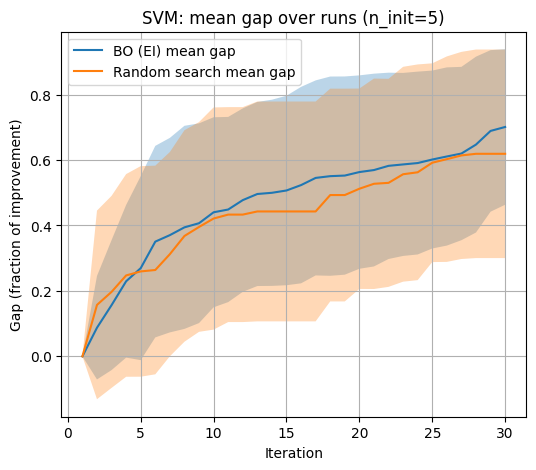

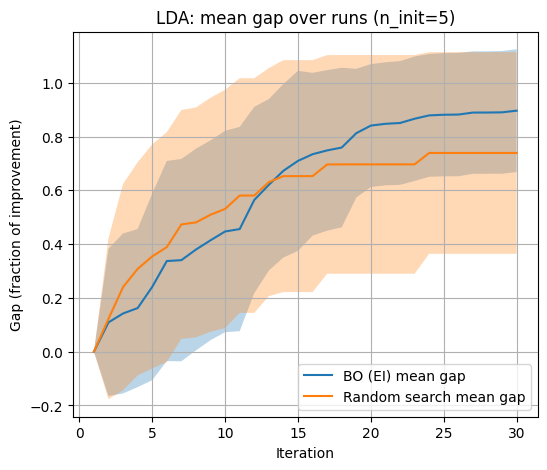

In [ ]:
best_kernel_svm = gp_svm.kernel_
best_kernel_lda = gp_lda.kernel_
BO_HIST_SVM, RS_HIST_SVM, BO_MEAN_SVM, RS_MEAN_SVM = multi_runs(
        svm_x, svm_y,
        fixed_kernel=best_kernel_svm,
        n_init=5,
        n_iter=30,
        n_runs=20,

)

BO_HIST_LDA, RS_HIST_LDA, BO_MEAN_LDA, RS_MEAN_LDA = multi_runs(
        lda_x, lda_y,
        fixed_kernel=best_kernel_lda,
        n_init=5,
        n_iter=30,
        n_runs=20
)


y_min_svm = svm_y.min()
y_min_lda = lda_y.min()

BO_GAP_SVM = compute_gap(BO_HIST_SVM, y_min_svm, n_init=5)
RS_GAP_SVM = compute_gap(RS_HIST_SVM, y_min_svm, n_init=5)

BO_GAP_LDA = compute_gap(BO_HIST_LDA, y_min_lda, n_init=5)
RS_GAP_LDA = compute_gap(RS_HIST_LDA, y_min_lda, n_init=5)

plot_gap_curves(BO_GAP_SVM, RS_GAP_SVM, n_init=5, dataset_name="SVM")

plot_gap_curves(BO_GAP_LDA, RS_GAP_LDA, n_init=5, dataset_name="LDA")


## More Iterations (shift)

Run 1/20 done.
Run 2/20 done.
Run 3/20 done.
Run 4/20 done.
Run 5/20 done.
Run 6/20 done.
Run 7/20 done.
Run 8/20 done.
Run 9/20 done.
Run 10/20 done.
Run 11/20 done.
Run 12/20 done.
Run 13/20 done.
Run 14/20 done.
Run 15/20 done.
Run 16/20 done.
Run 17/20 done.
Run 18/20 done.
Run 19/20 done.
Run 20/20 done.


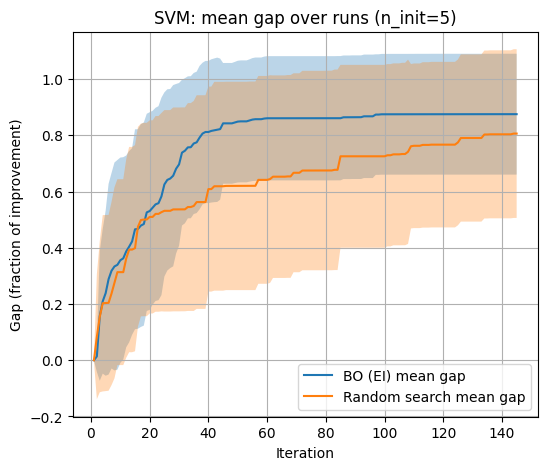


=== SVM: Summary over obs_list = [30, 60, 90, 120, 150] ===
obs= 30 | BO gap=0.625, RS gap=0.532, t=0.773, p=0.4492
obs= 60 | BO gap=0.856, RS gap=0.621, t=3.240, p=0.004308
obs= 90 | BO gap=0.861, RS gap=0.726, t=2.365, p=0.0288
obs=120 | BO gap=0.875, RS gap=0.766, t=2.367, p=0.02869
obs=150 | BO gap=0.875, RS gap=0.806, t=1.575, p=0.1318

Run 1/20 done.
Run 2/20 done.
Run 3/20 done.
Run 4/20 done.
Run 5/20 done.
Run 6/20 done.
Run 7/20 done.
Run 8/20 done.
Run 9/20 done.
Run 10/20 done.
Run 11/20 done.
Run 12/20 done.
Run 13/20 done.
Run 14/20 done.
Run 15/20 done.
Run 16/20 done.
Run 17/20 done.
Run 18/20 done.
Run 19/20 done.
Run 20/20 done.


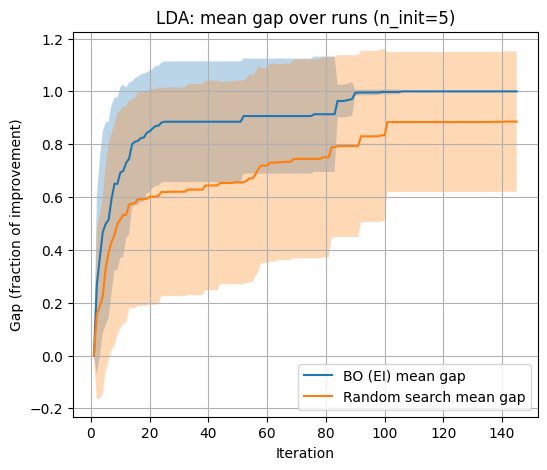


=== LDA: Summary over obs_list = [30, 60, 90, 120, 150] ===
obs= 30 | BO gap=0.885, RS gap=0.619, t=3.567, p=0.002056
obs= 60 | BO gap=0.907, RS gap=0.671, t=2.908, p=0.009025
obs= 90 | BO gap=0.964, RS gap=0.793, t=2.218, p=0.03893
obs=120 | BO gap=1.000, RS gap=0.884, t=1.910, p=0.0713
obs=150 | BO gap=1.000, RS gap=0.886, t=1.879, p=0.07572



In [ ]:
n_init = 5
n_iter = 145     # 足够大，能覆盖到 150 个 observations
n_runs = 20

# SVM
svm_results, svm_bo_gaps, svm_rs_gaps = run_bo_vs_random_experiment(
    svm_x, svm_y,
    fixed_kernel=best_kernel_svm,
    dataset_name="SVM",
    n_init=n_init,
    n_iter=n_iter,
    n_runs=n_runs,
    obs_list=(30, 60, 90, 120, 150),
    base_seed=200,
    do_plot=True
)

# LDA
lda_results, lda_bo_gaps, lda_rs_gaps = run_bo_vs_random_experiment(
    lda_x, lda_y,
    fixed_kernel=best_kernel_lda,
    dataset_name="LDA",
    n_init=n_init,
    n_iter=n_iter,
    n_runs=n_runs,
    obs_list=(30, 60, 90, 120, 150),
    base_seed=500,
    do_plot=True
)


Run 1/20 done.
Run 2/20 done.
Run 3/20 done.
Run 4/20 done.
Run 5/20 done.
Run 6/20 done.
Run 7/20 done.
Run 8/20 done.
Run 9/20 done.
Run 10/20 done.
Run 11/20 done.
Run 12/20 done.
Run 13/20 done.
Run 14/20 done.
Run 15/20 done.
Run 16/20 done.
Run 17/20 done.
Run 18/20 done.
Run 19/20 done.
Run 20/20 done.
Run 1/20 done.
Run 2/20 done.
Run 3/20 done.
Run 4/20 done.
Run 5/20 done.
Run 6/20 done.
Run 7/20 done.
Run 8/20 done.
Run 9/20 done.
Run 10/20 done.
Run 11/20 done.
Run 12/20 done.
Run 13/20 done.
Run 14/20 done.
Run 15/20 done.
Run 16/20 done.
Run 17/20 done.
Run 18/20 done.
Run 19/20 done.
Run 20/20 done.


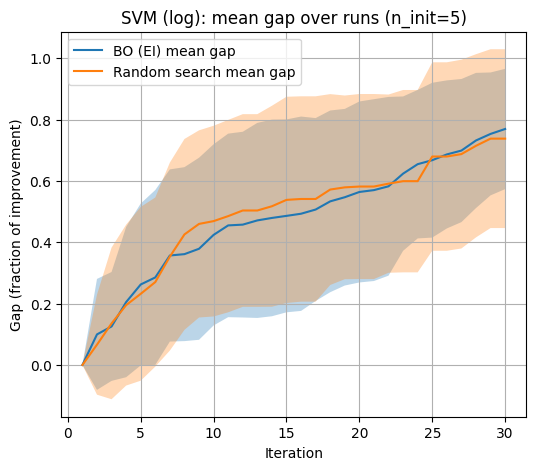

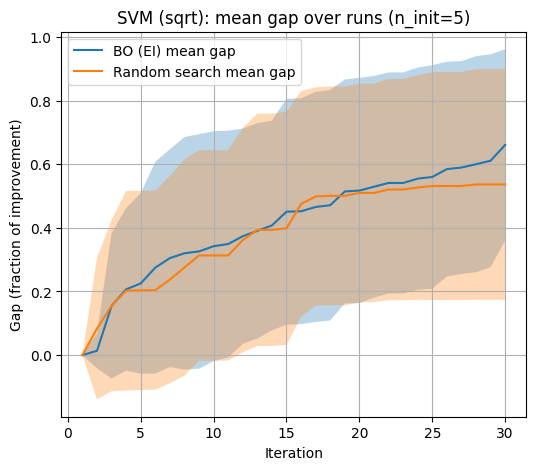

In [ ]:
# 之前从 full data 学出来的 kernel
# 假设你前面已经有类似代码：
# gp_svm_full, y_train_svm_full = fit_gp('shift', svm_x, svm_y, ...)
# best_kernel_svm = gp_svm_full.kernel_

best_kernel_log_svm  = best_kernel_svm
best_kernel_sqrt_svm = best_kernel_svm




BO_LOG_SVM, RS_LOG_SVM, BO_LOG_MEAN_SVM, RS_LOG_MEAN_SVM = multi_runs(
    svm_x, svm_y, best_kernel_log_svm,
    n_init=5, n_iter=30, n_runs=20,
    base_seed=100,
    model="log",
)

# sqrt 变换
BO_SQRT_SVM, RS_SQRT_SVM, BO_SQRT_MEAN_SVM, RS_SQRT_MEAN_SVM = multi_runs(
    svm_x, svm_y, best_kernel_sqrt_svm,
    n_init=5, n_iter=30, n_runs=20,
    base_seed=200,
    model="sqrt",
)

BO_GAP_SVM_LOG = compute_gap(BO_LOG_SVM, y_min_svm, n_init=5)
RS_GAP_SVM_LOG = compute_gap(RS_LOG_SVM, y_min_svm, n_init=5)

plot_gap_curves(BO_GAP_SVM_LOG, RS_GAP_SVM_LOG, n_init=5,
                dataset_name="SVM (log)")



BO_GAP_SVM_SQRT = compute_gap(BO_SQRT_SVM, y_min_svm, n_init=5)
RS_GAP_SVM_SQRT = compute_gap(RS_SQRT_SVM, y_min_svm, n_init=5)

plot_gap_curves(BO_GAP_SVM_SQRT, RS_GAP_SVM_SQRT, n_init=5,
                dataset_name="SVM (sqrt)")

# Branin _ Best Transform

In [ ]:

def expected_improvement_grid(mu, sigma, y_best, minimize=True):
    """
    mu, sigma: 网格上 GP 的预测均值、标准差 (2D array 或 1D 后再 reshape)
    y_best:    当前训练数据里的 best y（最小化）
    返回：和 mu 同 shape 的 EI
    """
    sigma = np.maximum(sigma, 1e-9)  # 防止除 0

    if minimize:
        imp = y_best - mu          # 想比当前 best 再小
    else:
        imp = mu - y_best          # 若是最大化的话

    Z = imp / sigma
    ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
    ei[sigma < 1e-9] = 0.0
    return ei


def plot_branin_bo_maps(x1, x2, mu_grid, std_grid, ei_grid, X_train):
    """
    三联图：
      左：posterior mean
      中：posterior std + 训练点
      右：Expected Improvement + 训练点 + EI 最大点
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 4))
    extent = [x1.min(), x1.max(), x2.min(), x2.max()]

    # 1. posterior mean
    im0 = axes[0].imshow(mu_grid, origin='lower', extent=extent, aspect='auto')
    axes[0].set_title("GP posterior mean")
    axes[0].set_xlabel("$x_1$")
    axes[0].set_ylabel("$x_2$")
    plt.colorbar(im0, ax=axes[0])

    # 2. posterior std
    im1 = axes[1].imshow(std_grid, origin='lower', extent=extent, aspect='auto')
    axes[1].scatter(X_train[:, 0], X_train[:, 1],
                    s=20, c='white', edgecolors='k', label='Sobol samples')
    axes[1].set_title("GP posterior std")
    axes[1].set_xlabel("$x_1$")
    plt.colorbar(im1, ax=axes[1])
    axes[1].legend(loc='upper right')

    # 3. EI
    im2 = axes[2].imshow(ei_grid, origin='lower', extent=extent, aspect='auto')
    # EI 最大点
    max_flat_idx = np.argmax(ei_grid)
    max_j, max_i = np.unravel_index(max_flat_idx, ei_grid.shape)
    x1_star = x1[max_i]
    x2_star = x2[max_j]

    axes[2].scatter(X_train[:, 0], X_train[:, 1],
                    s=20, c='white', edgecolors='k', alpha=0.6, label='Sobol samples')
    axes[2].scatter(x1_star, x2_star,
                    marker='*', s=180, c='red', edgecolors='k', label='max EI')
    axes[2].set_title("Expected Improvement (minimization)")
    axes[2].set_xlabel("$x_1$")
    plt.colorbar(im2, ax=axes[2])
    axes[2].legend(loc='upper right')

    plt.tight_layout()
    plt.show()

    print(f"EI 最大点大概在: x1 = {x1_star:.3f}, x2 = {x2_star:.3f}")
    return x1_star, x2_star

# 画图 & 输出 EI 最大点



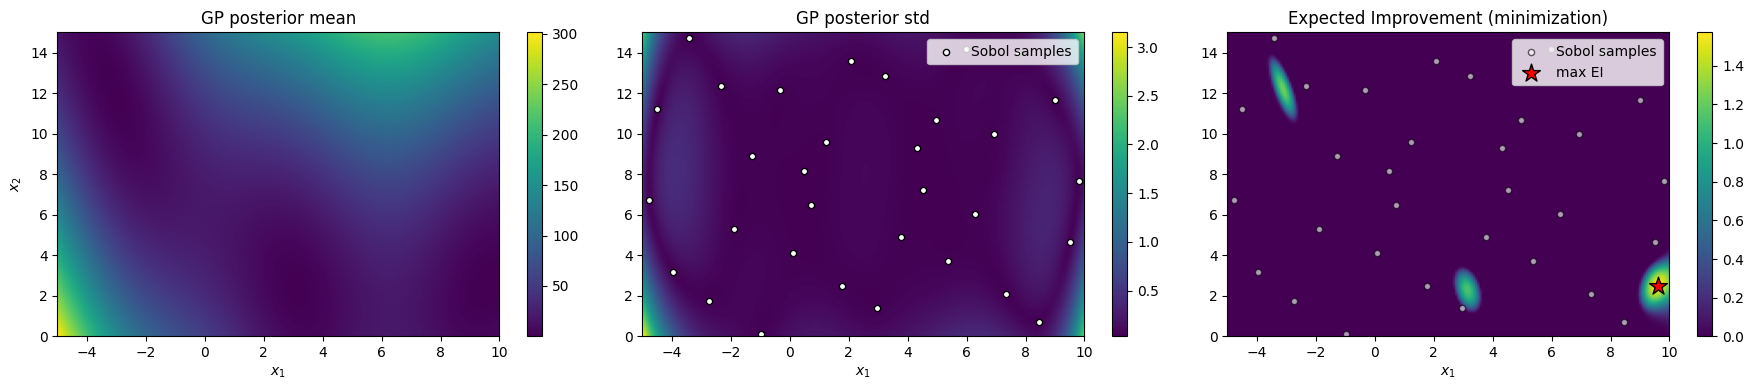

EI 最大点大概在: x1 = 9.623, x2 = 2.487


In [ ]:
# 网格分辨率，你可以改成 150 或 200，看电脑撑不撑得住
N_grid = 200

x1 = np.linspace(x1_min, x1_max, N_grid)
x2 = np.linspace(x2_min, x2_max, N_grid)
X1g, X2g = np.meshgrid(x1, x2)
X_grid = np.column_stack([X1g.ravel(), X2g.ravel()])  # (N_grid^2, 2)

# GP 预测
mu_flat, std_flat = gp_shift.predict(X_grid, return_std=True)
mu_grid  = mu_flat.reshape(N_grid, N_grid)
std_grid = std_flat.reshape(N_grid, N_grid)

# 当前训练集中最小的 y，用来算 EI
y_best_train = Y_shift.min()

# EI 网格（最小化版本）
ei_grid = expected_improvement_grid(mu_grid, std_grid, y_best_train, minimize=True)

x1_star, x2_star = plot_branin_bo_maps(x1, x2, mu_grid, std_grid, ei_grid, X_shift)
